In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import ToTensor, transforms
import torch.nn.functional as F
from typing import Optional

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score

import cv2
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# COVID_NET

In [2]:
class Flatten(nn.Module):
    """Flattens the input tensor for use in the neural network.

    This class defines the operation to flatten an input tensor.
    """

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        """Flattens the input tensor.

        Args:
            input (torch.Tensor): The input tensor.

        Returns:
            torch.Tensor: The flattened tensor.
        """
        return input.view(input.size(0), -1)


class PEPX(nn.Module):
    """Defines the PEPX Convolutional Neural Network architecture.

    This class creates a PEPX model, which contains several convolutional layers
    for feature projection, expansion, depth-wise representation, second-stage
    projection, and final extension.

    Args:
        n_input (int): The number of input features.
        n_out (int): The number of output features.

    Attributes:
        network (nn.Sequential): The neural network layers.
    """

    def __init__(self, n_input: int, n_out: int):
        super(PEPX, self).__init__()  # Call the __init__() method of the parent class
        self.network = nn.Sequential(nn.Conv2d(in_channels=n_input, out_channels=n_input // 2, kernel_size=1),
                                     nn.Conv2d(in_channels=n_input // 2, out_channels=int(3 * n_input / 4),
                                               kernel_size=1),
                                     nn.Conv2d(in_channels=int(3 * n_input / 4), out_channels=int(3 * n_input / 4),
                                               kernel_size=3, groups=int(3 * n_input / 4), padding=1),
                                     nn.Conv2d(in_channels=int(3 * n_input / 4), out_channels=n_input // 2,
                                               kernel_size=1),
                                     nn.Conv2d(in_channels=n_input // 2, out_channels=n_out, kernel_size=1),
                                     nn.BatchNorm2d(n_out))
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Defines the forward pass of the PEPX model.

        Args:
            x (torch.Tensor): The input tensor.

        Returns:
            torch.Tensor: The output tensor, result of the forward pass of the model.
        """
        return self.network(x)

class CovidNet(nn.Module):
    """Defines the CovidNet model architecture for classification tasks.

    The architecture consists of a sequence of PEPX blocks and linear layers. It can be built
    in a small or large configuration depending on the model parameter.

    Args:
        model (str): Model type, either 'small' or 'large'. Defaults to 'small'.
        n_classes (int): Number of classes for the final classification. Defaults to 3.

    Attributes:
        All the PEPX blocks and other layers in the network.
    """

    def __init__(self, model: str = 'small', n_classes: int = 2):
        super(CovidNet, self).__init__()

        filters = {
            'pepx1_1': [56, 56],
            'pepx1_2': [56, 56],
            'pepx1_3': [56, 56],
            'pepx2_1': [56, 112],
            'pepx2_2': [112, 112],
            'pepx2_3': [112, 112],
            'pepx2_4': [112, 112],
            'pepx3_1': [112, 216],
            'pepx3_2': [216, 216],
            'pepx3_3': [216, 216],
            'pepx3_4': [216, 216],
            'pepx3_5': [216, 216],
            'pepx3_6': [216, 216],
            'pepx4_1': [216, 424],
            'pepx4_2': [424, 424],
            'pepx4_3': [424, 424],
        }

        self.add_module('conv1', nn.Conv2d(in_channels=1, out_channels=56, kernel_size=7, stride=2, padding=3))
        for key in filters:

            if ('pool' in key):
                self.add_module(key, nn.MaxPool2d(filters[key][0], filters[key][1]))
            else:
                self.add_module(key, PEPX(filters[key][0], filters[key][1]))

        if (model == 'large'):

            self.add_module('conv1_1x1', nn.Conv2d(in_channels=56, out_channels=112, kernel_size=1))
            self.add_module('conv2_1x1', nn.Conv2d(in_channels=112, out_channels=216, kernel_size=1))
            self.add_module('conv3_1x1', nn.Conv2d(in_channels=216, out_channels=424, kernel_size=1))
            self.add_module('conv4_1x1', nn.Conv2d(in_channels=424, out_channels=424, kernel_size=1))

            self.__forward__ = self.forward_large_net
        else:
            self.__forward__ = self.forward_small_net
        self.add_module('flatten', Flatten())
        self.add_module('fc1', nn.Linear(27136, 512))

        self.add_module('classifier', nn.Linear(512, 1))
        self.sigmoid = nn.Sigmoid()

        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Defines the computation performed at every call.

        Args:
            x (torch.Tensor): The input tensor.

        Returns:
            torch.Tensor: The output tensor.
        """
        return self.__forward__(x)

    def forward_small_net(self, x: torch.Tensor) -> torch.Tensor:
        """Defines the forward pass for the small model variant.

        Args:
            x (torch.Tensor): The input tensor.

        Returns:
            torch.Tensor: The output tensor, result of the forward pass of the small model.
        """
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)

        pepx11 = self.pepx1_1(x)
        pepx12 = self.pepx1_2(pepx11)
        pepx13 = self.pepx1_3(pepx12 + pepx11)

        pepx21 = self.pepx2_1(F.max_pool2d(pepx13, 2) + F.max_pool2d(pepx11, 2) + F.max_pool2d(pepx12, 2))
        pepx22 = self.pepx2_2(pepx21)
        pepx23 = self.pepx2_3(pepx22 + pepx21)
        pepx24 = self.pepx2_4(pepx23 + pepx21 + pepx22)

        pepx31 = self.pepx3_1(
            F.max_pool2d(pepx24, 2) + F.max_pool2d(pepx21, 2) + F.max_pool2d(pepx22, 2) + F.max_pool2d(pepx23, 2))
        pepx32 = self.pepx3_2(pepx31)
        pepx33 = self.pepx3_3(pepx31 + pepx32)
        pepx34 = self.pepx3_4(pepx31 + pepx32 + pepx33)
        pepx35 = self.pepx3_5(pepx31 + pepx32 + pepx33 + pepx34)
        pepx36 = self.pepx3_6(pepx31 + pepx32 + pepx33 + pepx34 + pepx35)

        pepx41 = self.pepx4_1(
            F.max_pool2d(pepx31, 2) + F.max_pool2d(pepx32, 2) + F.max_pool2d(pepx32, 2) + F.max_pool2d(pepx34,
                                                                                                       2) + F.max_pool2d(
                pepx35, 2) + F.max_pool2d(pepx36, 2))
        pepx42 = self.pepx4_2(pepx41)
        pepx43 = self.pepx4_3(pepx41 + pepx42)
        flattened = self.flatten(pepx41 + pepx42 + pepx43)

        fc1out = F.relu(self.fc1(flattened))
        # fc2out = F.relu(self.fc2(fc1out))
        logits = self.classifier(fc1out)
        logits = torch.squeeze(logits, dim=1)
        logits = self.sigmoid(logits)

        return logits

In [3]:
class CovidNetDataset(Dataset):
    def __init__(self, data):
        self.data = data
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Grayscale()  # Added transform to convert to grayscale
        ])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        image, label = self.data[index]
        image = (image - image.min()) / (image.max() - image.min()) 
        image = cv2.resize(image, (256, 256))
        image = self.transform(image).float()

        return image, label

In [4]:
import os
import numpy as np
from tqdm import tqdm
from skimage import io

# Path to the Dataset folder
dataset_folder = "./Dataset"

# List to store the dataset
dataset = []

# Iterate over the subfolders (0 and 1)
for label in ["0", "1"]:
    label_folder = os.path.join(dataset_folder, label)

    # Iterate over the images in the label folder
    for image_file in tqdm(os.listdir(label_folder), desc=f"Processing label {label}"):
        if image_file.endswith(".png"):
            image_path = os.path.join(label_folder, image_file)

            # Load the image using skimage's io.imread
            image = io.imread(image_path)
            # Append the image and label to the dataset list
            dataset.append((image, int(label)))

Processing label 1: 100%|██████████| 2055/2055 [00:54<00:00, 38.05it/s]


In [5]:
# Print the number of images in the dataset
print("Number of images in the dataset:", len(dataset))
print(dataset[0])

Number of images in the dataset: 4060
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8), 0)


In [6]:
# Split the dataset into training and test sets
train_dataset, test_dataset = train_test_split(dataset, test_size=0.2, random_state=42)

# Split the test set into validation and final test sets
val_dataset, test_dataset = train_test_split(test_dataset, test_size=0.5, random_state=42)

# Create data loaders
batch_size = 16
train_loader = DataLoader(CovidNetDataset(train_dataset), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(CovidNetDataset(val_dataset), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(CovidNetDataset(test_dataset), batch_size=batch_size, shuffle=True)

# Initialize the ResNet classifier
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 2

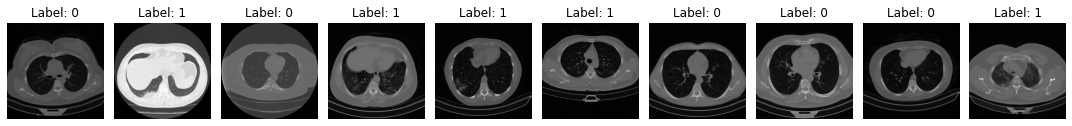

In [7]:
import matplotlib.pyplot as plt

# Function to visualize images with labels
def visualize_images(dataset, num_images=10):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))

    for i in range(num_images):
        image, label = dataset[i]
        axes[i].imshow(image, cmap="gray")
        axes[i].set_title(f"Label: {label}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Visualize some images from the train dataset
visualize_images(train_dataset)

In [ ]:
model = CovidNet().to(device)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
model

CovidNet(
  (conv1): Conv2d(1, 56, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (pepx1_1): PEPX(
    (network): Sequential(
      (0): Conv2d(56, 28, kernel_size=(1, 1), stride=(1, 1))
      (1): Conv2d(28, 42, kernel_size=(1, 1), stride=(1, 1))
      (2): Conv2d(42, 42, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=42)
      (3): Conv2d(42, 28, kernel_size=(1, 1), stride=(1, 1))
      (4): Conv2d(28, 56, kernel_size=(1, 1), stride=(1, 1))
      (5): BatchNorm2d(56, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (pepx1_2): PEPX(
    (network): Sequential(
      (0): Conv2d(56, 28, kernel_size=(1, 1), stride=(1, 1))
      (1): Conv2d(28, 42, kernel_size=(1, 1), stride=(1, 1))
      (2): Conv2d(42, 42, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=42)
      (3): Conv2d(42, 28, kernel_size=(1, 1), stride=(1, 1))
      (4): Conv2d(28, 56, kernel_size=(1, 1), stride=(1, 1))
      (5): BatchNorm2d(56, eps=1e-05, momentum=0.1, affin

In [ ]:
# Define empty lists to store loss and accuracy values
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

best_val_accuracy = 0.0  # Track the best validation accuracy
best_model_state_dict = None  # Store the state dict of the best model

print("---------Training phase----------")

num_epochs = 10
for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    train_correct = 0

    train_predictions = []
    train_true_labels = []

    with tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs} - Train", ncols=80) as pbar_train:
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(images)
            predicted = torch.round(outputs)
            train_correct += (predicted == labels).sum().item()
            train_predictions.extend(predicted.tolist())
            train_true_labels.extend(labels.tolist())

            loss = criterion(outputs, labels.float())

            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)
            pbar_train.set_postfix({'Loss': loss.item()})
            pbar_train.update()

    train_accuracy = train_correct / len(train_dataset)
    train_loss /= len(train_dataset)

    # Validation phase
    model.eval()

    val_correct = 0
    val_loss = 0.0
    val_predictions = []
    val_true_labels = []

    with tqdm(val_loader, desc=f"Epoch {epoch + 1}/{num_epochs} - Validation", ncols=80) as pbar_val:
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)

                predicted = torch.round(outputs)
                val_correct += (predicted == labels).sum().item()
                val_predictions.extend(predicted.tolist())
                val_true_labels.extend(labels.tolist())

                loss = criterion(outputs, labels.float())
                val_loss += loss.item() * images.size(0)
                pbar_val.set_postfix({'Loss': loss.item()})
                pbar_val.update()

    val_accuracy = val_correct / len(val_dataset)
    val_loss /= len(val_dataset)
    val_precision = precision_score(val_true_labels, val_predictions)
    val_recall = recall_score(val_true_labels, val_predictions)

    # Append accuracy and loss to the respective lists
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    # Check if the current validation accuracy is better than the previous best
    if val_accuracy > best_val_accuracy:
        print("The Best Model SAVED!")
        best_val_accuracy = val_accuracy
        best_model_state_dict = model.state_dict()

    # Print epoch statistics
    print(f"Epoch {epoch + 1}/{num_epochs} - Train Loss: {train_loss:.4f} - Train Acc: {train_accuracy:.4f} - "
          f"Val Loss: {val_loss:.4f} - Val Acc: {val_accuracy:.4f} - Val Precision: {val_precision:.4f} - "
          f"Val Recall: {val_recall:.4f}")

# Save the best model's state dictionary
torch.save(best_model_state_dict, './local_server_1_COVIDNET.pth')

In [ ]:
# Plotting the loss and accuracy curves
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train')
plt.plot(val_accuracies, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Load the saved best model's state dictionary
best_model_state_dict = torch.load('./local_server_1_COVIDNET.pth')

# Set the best model's state dictionary to the model
model.load_state_dict(best_model_state_dict)

# Testing phase
model.eval()
test_predictions = []
test_true_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)

        predicted = torch.round(outputs)
        test_predictions.extend(predicted.tolist())
        test_true_labels.extend(labels.tolist())

# Calculate performance metrics
test_accuracy = accuracy_score(test_true_labels, test_predictions)
test_precision = precision_score(test_true_labels, test_predictions)
test_recall = recall_score(test_true_labels, test_predictions)
test_f1_score = f1_score(test_true_labels, test_predictions)


In [ ]:
# Print performance metrics
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1 Score: {test_f1_score:.4f}")

# Create confusion matrix
cm = confusion_matrix(test_true_labels, test_predictions)

# Plot confusion matrix
class_names = ['Negative', 'Positive']  # Modify class names based on your dataset
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, square=True,
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# RESNET

In [9]:
from torchvision.models import resnet18, resnet101, resnet50, ResNet18_Weights

class ResNetClassifier(nn.Module):
    def __init__(self):
        super(ResNetClassifier, self).__init__()
        self.resnet = resnet18(weights=None)
        num_features = self.resnet.fc.in_features
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.resnet.fc = nn.Linear(num_features, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.resnet(x)
        x = torch.squeeze(x, dim=1)
        x = self.sigmoid(x)
        return x

In [10]:
model = ResNetClassifier().to(device)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [24]:
# Define empty lists to store loss and accuracy values
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

best_val_accuracy = 0.0  # Track the best validation accuracy
best_model_state_dict = None  # Store the state dict of the best model

print("---------Training phase----------")

num_epochs = 20
for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    train_correct = 0

    train_predictions = []
    train_true_labels = []

    with tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs} - Train", ncols=80) as pbar_train:
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(images)
            predicted = torch.round(outputs)
            train_correct += (predicted == labels).sum().item()
            train_predictions.extend(predicted.tolist())
            train_true_labels.extend(labels.tolist())

            loss = criterion(outputs, labels.float())

            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)
            pbar_train.set_postfix({'Loss': loss.item()})
            pbar_train.update()

    train_accuracy = train_correct / len(train_dataset)
    train_loss /= len(train_dataset)

    # Validation phase
    model.eval()

    val_correct = 0
    val_loss = 0.0
    val_predictions = []
    val_true_labels = []

    with tqdm(val_loader, desc=f"Epoch {epoch + 1}/{num_epochs} - Validation", ncols=80) as pbar_val:
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)

                predicted = torch.round(outputs)
                val_correct += (predicted == labels).sum().item()
                val_predictions.extend(predicted.tolist())
                val_true_labels.extend(labels.tolist())

                loss = criterion(outputs, labels.float())
                val_loss += loss.item() * images.size(0)
                pbar_val.set_postfix({'Loss': loss.item()})
                pbar_val.update()

    val_accuracy = val_correct / len(val_dataset)
    val_loss /= len(val_dataset)
    val_precision = precision_score(val_true_labels, val_predictions)
    val_recall = recall_score(val_true_labels, val_predictions)

    # Append accuracy and loss to the respective lists
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    # Check if the current validation accuracy is better than the previous best
    if val_accuracy > best_val_accuracy:
        print("The Best Model SAVED!")
        best_val_accuracy = val_accuracy
        best_model_state_dict = model.state_dict()

    # Print epoch statistics
    print(f"Epoch {epoch + 1}/{num_epochs} - Train Loss: {train_loss:.4f} - Train Acc: {train_accuracy:.4f} - "
          f"Val Loss: {val_loss:.4f} - Val Acc: {val_accuracy:.4f} - Val Precision: {val_precision:.4f} - "
          f"Val Recall: {val_recall:.4f}")

# Save the best model's state dictionary
torch.save(best_model_state_dict, './local_server_1_RESNET.pth')

---------Training phase----------


Epoch 1/20 - Validation: 100%|█████| 26/26 [00:02<00:00, 11.85it/s, Loss=0.0786]


The Best Model SAVED!
Epoch 1/20 - Train Loss: 0.3492 - Train Acc: 0.8381 - Val Loss: 0.3795 - Val Acc: 0.7611 - Val Precision: 0.6850 - Val Recall: 0.9110


Epoch 2/20 - Validation: 100%|██████| 26/26 [00:02<00:00, 12.06it/s, Loss=0.338]


The Best Model SAVED!
Epoch 2/20 - Train Loss: 0.2538 - Train Acc: 0.8889 - Val Loss: 0.2708 - Val Acc: 0.8768 - Val Precision: 0.9548 - Val Recall: 0.7749


Epoch 3/20 - Validation: 100%|██████| 26/26 [00:02<00:00, 12.17it/s, Loss=0.325]


The Best Model SAVED!
Epoch 3/20 - Train Loss: 0.1946 - Train Acc: 0.9153 - Val Loss: 0.2391 - Val Acc: 0.8842 - Val Precision: 0.8243 - Val Recall: 0.9581


Epoch 4/20 - Validation: 100%|████| 26/26 [00:02<00:00, 12.48it/s, Loss=0.00716]


The Best Model SAVED!
Epoch 4/20 - Train Loss: 0.1535 - Train Acc: 0.9412 - Val Loss: 0.1449 - Val Acc: 0.9483 - Val Precision: 0.9722 - Val Recall: 0.9162


Epoch 5/20 - Validation: 100%|██████| 26/26 [00:02<00:00, 12.17it/s, Loss=0.491]


Epoch 5/20 - Train Loss: 0.1272 - Train Acc: 0.9526 - Val Loss: 0.1878 - Val Acc: 0.9138 - Val Precision: 0.8714 - Val Recall: 0.9581


Epoch 6/20 - Validation: 100%|█████| 26/26 [00:02<00:00, 12.14it/s, Loss=0.0635]


Epoch 6/20 - Train Loss: 0.1021 - Train Acc: 0.9606 - Val Loss: 0.2621 - Val Acc: 0.8744 - Val Precision: 0.7893 - Val Recall: 1.0000


Epoch 7/20 - Validation: 100%|████| 26/26 [00:02<00:00, 12.11it/s, Loss=0.00143]


The Best Model SAVED!
Epoch 7/20 - Train Loss: 0.1047 - Train Acc: 0.9594 - Val Loss: 0.0521 - Val Acc: 0.9778 - Val Precision: 0.9691 - Val Recall: 0.9843


Epoch 8/20 - Validation: 100%|███████| 26/26 [00:02<00:00, 11.71it/s, Loss=1.01]


Epoch 8/20 - Train Loss: 0.0682 - Train Acc: 0.9732 - Val Loss: 0.1237 - Val Acc: 0.9557 - Val Precision: 0.9139 - Val Recall: 1.0000


Epoch 9/20 - Validation: 100%|████| 26/26 [00:02<00:00, 11.73it/s, Loss=0.00647]


Epoch 9/20 - Train Loss: 0.0749 - Train Acc: 0.9714 - Val Loss: 0.0752 - Val Acc: 0.9778 - Val Precision: 0.9550 - Val Recall: 1.0000


Epoch 10/20 - Validation: 100%|███| 26/26 [00:02<00:00, 11.60it/s, Loss=0.00345]


The Best Model SAVED!
Epoch 10/20 - Train Loss: 0.0500 - Train Acc: 0.9840 - Val Loss: 0.0497 - Val Acc: 0.9852 - Val Precision: 0.9894 - Val Recall: 0.9791


Epoch 11/20 - Validation: 100%|█████| 26/26 [00:02<00:00, 11.80it/s, Loss=0.015]


The Best Model SAVED!
Epoch 11/20 - Train Loss: 0.0619 - Train Acc: 0.9794 - Val Loss: 0.0614 - Val Acc: 0.9877 - Val Precision: 0.9745 - Val Recall: 1.0000


Epoch 12/20 - Validation: 100%|██| 26/26 [00:02<00:00, 11.34it/s, Loss=0.000659]


Epoch 12/20 - Train Loss: 0.0407 - Train Acc: 0.9843 - Val Loss: 0.0520 - Val Acc: 0.9803 - Val Precision: 0.9598 - Val Recall: 1.0000


Epoch 13/20 - Validation: 100%|███| 26/26 [00:02<00:00, 12.35it/s, Loss=7.37e-5]


Epoch 13/20 - Train Loss: 0.0301 - Train Acc: 0.9905 - Val Loss: 0.0294 - Val Acc: 0.9852 - Val Precision: 0.9894 - Val Recall: 0.9791


Epoch 14/20 - Validation: 100%|██| 26/26 [00:02<00:00, 12.03it/s, Loss=0.000312]


Epoch 14/20 - Train Loss: 0.0185 - Train Acc: 0.9929 - Val Loss: 0.0294 - Val Acc: 0.9877 - Val Precision: 0.9947 - Val Recall: 0.9791


Epoch 15/20 - Validation: 100%|█████| 26/26 [00:02<00:00, 12.17it/s, Loss=0.526]


Epoch 15/20 - Train Loss: 0.0644 - Train Acc: 0.9821 - Val Loss: 0.0979 - Val Acc: 0.9655 - Val Precision: 0.9317 - Val Recall: 1.0000


Epoch 16/20 - Validation: 100%|██| 26/26 [00:02<00:00, 12.13it/s, Loss=0.000167]


Epoch 16/20 - Train Loss: 0.0163 - Train Acc: 0.9942 - Val Loss: 0.1053 - Val Acc: 0.9729 - Val Precision: 0.9455 - Val Recall: 1.0000


Epoch 17/20 - Validation: 100%|███| 26/26 [00:02<00:00, 12.20it/s, Loss=5.67e-6]


Epoch 17/20 - Train Loss: 0.0272 - Train Acc: 0.9883 - Val Loss: 0.0871 - Val Acc: 0.9754 - Val Precision: 0.9892 - Val Recall: 0.9581


Epoch 18/20 - Validation: 100%|████| 26/26 [00:02<00:00, 11.70it/s, Loss=0.0106]


Epoch 18/20 - Train Loss: 0.0103 - Train Acc: 0.9960 - Val Loss: 0.1794 - Val Acc: 0.9606 - Val Precision: 0.9227 - Val Recall: 1.0000


Epoch 19/20 - Validation: 100%|████| 26/26 [00:02<00:00, 11.67it/s, Loss=0.0134]


The Best Model SAVED!
Epoch 19/20 - Train Loss: 0.0165 - Train Acc: 0.9935 - Val Loss: 0.0186 - Val Acc: 0.9951 - Val Precision: 0.9948 - Val Recall: 0.9948


Epoch 20/20 - Validation: 100%|███| 26/26 [00:02<00:00, 11.85it/s, Loss=3.93e-5]


Epoch 20/20 - Train Loss: 0.0910 - Train Acc: 0.9821 - Val Loss: 0.0571 - Val Acc: 0.9778 - Val Precision: 0.9892 - Val Recall: 0.9634


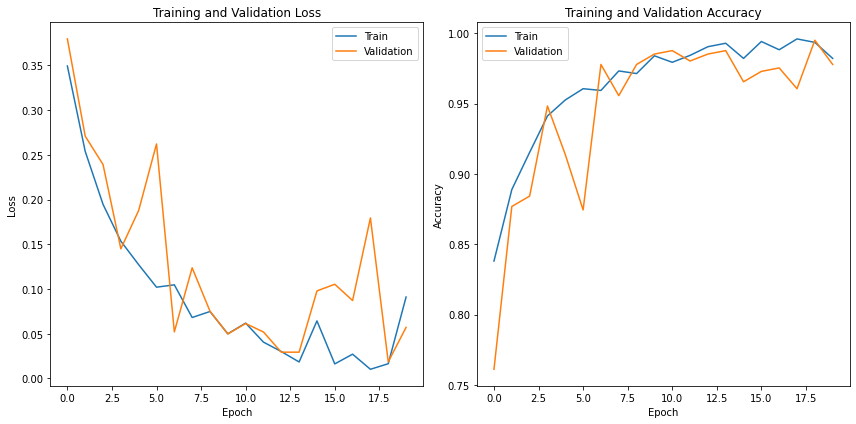

In [25]:
# Plotting the loss and accuracy curves
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train')
plt.plot(val_accuracies, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [21]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Load the saved best model's state dictionary
best_model_state_dict = torch.load('./local_server_1_RESNET.pth')

# Set the best model's state dictionary to the model
model.load_state_dict(best_model_state_dict)

# Testing phase
model.eval()
test_predictions = []
test_true_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)

        predicted = torch.round(outputs)
        test_predictions.extend(predicted.tolist())
        test_true_labels.extend(labels.tolist())

# Calculate performance metrics
test_accuracy = accuracy_score(test_true_labels, test_predictions)
test_precision = precision_score(test_true_labels, test_predictions)
test_recall = recall_score(test_true_labels, test_predictions)
test_f1_score = f1_score(test_true_labels, test_predictions)

Test Accuracy: 0.9828
Test Precision: 0.9764
Test Recall: 0.9904
Test F1 Score: 0.9834


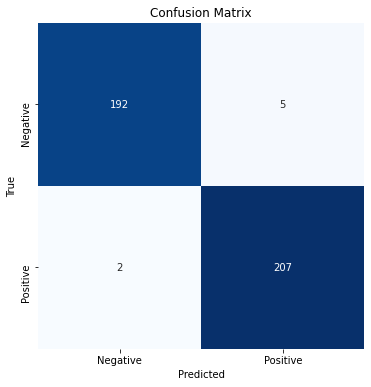

In [27]:
import seaborn as sns

# Print performance metrics
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1 Score: {test_f1_score:.4f}")

# Create confusion matrix
cm = confusion_matrix(test_true_labels, test_predictions)

# Plot confusion matrix
class_names = ['Negative', 'Positive']  # Modify class names based on your dataset
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, square=True,
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# AVG Global Model - Global Model Test

In [20]:
model = ResNetClassifier().to(device)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.000001)

In [22]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

gobal_model = ResNetClassifier().to(device)
# Load the saved best model's state dictionary
global_model_weights = torch.load('./AVG_global_model.pth')

# Set the best model's state dictionary to the model
gobal_model.load_state_dict(global_model_weights)

# Testing phase
gobal_model.eval()
test_predictions = []
test_true_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = gobal_model(images)

        predicted = torch.round(outputs)
        test_predictions.extend(predicted.tolist())
        test_true_labels.extend(labels.tolist())

# Calculate performance metrics
test_accuracy = accuracy_score(test_true_labels, test_predictions)
test_precision = precision_score(test_true_labels, test_predictions)
test_recall = recall_score(test_true_labels, test_predictions)
test_f1_score = f1_score(test_true_labels, test_predictions)

Test Accuracy: 0.7266
Test Precision: 0.8311
Test Recall: 0.5885
Test F1 Score: 0.6891


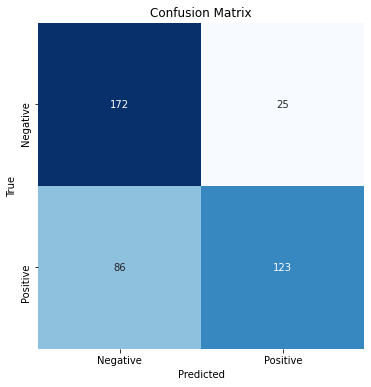

In [23]:
import seaborn as sns

# Print performance metrics
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1 Score: {test_f1_score:.4f}")

# Create confusion matrix
cm = confusion_matrix(test_true_labels, test_predictions)

# Plot confusion matrix
class_names = ['Negative', 'Positive']  # Modify class names based on your dataset
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, square=True,
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Global Model KD0 - Global Model Test

In [31]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

gobal_model = ResNetClassifier().to(device)
# Load the saved best model's state dictionary
global_model_weights = torch.load('./global_server_KD0_RESNET.pth')

# Set the best model's state dictionary to the model
gobal_model.load_state_dict(global_model_weights)

# Testing phase
gobal_model.eval()
test_predictions = []
test_true_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = gobal_model(images)

        predicted = torch.round(outputs)
        test_predictions.extend(predicted.tolist())
        test_true_labels.extend(labels.tolist())

# Calculate performance metrics
test_accuracy = accuracy_score(test_true_labels, test_predictions)
test_precision = precision_score(test_true_labels, test_predictions)
test_recall = recall_score(test_true_labels, test_predictions)
test_f1_score = f1_score(test_true_labels, test_predictions)

Test Accuracy: 0.7635
Test Precision: 0.6852
Test Recall: 1.0000
Test F1 Score: 0.8132


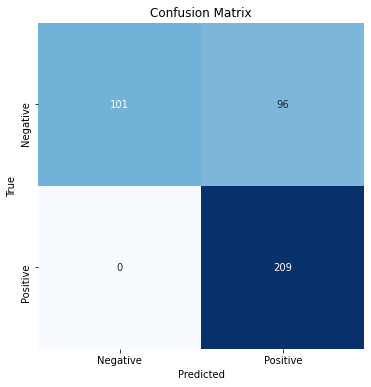

In [32]:
import seaborn as sns

# Print performance metrics
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1 Score: {test_f1_score:.4f}")

# Create confusion matrix
cm = confusion_matrix(test_true_labels, test_predictions)

# Plot confusion matrix
class_names = ['Negative', 'Positive']  # Modify class names based on your dataset
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, square=True,
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Global Model KD1 - Global Model Test

In [45]:
model = ResNetClassifier().to(device)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [46]:
# Define empty lists to store loss and accuracy values
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

best_val_accuracy = 0.0  # Track the best validation accuracy
best_model_state_dict = None  # Store the state dict of the best model

print("---------Training phase----------")

num_epochs = 1
for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    train_correct = 0

    train_predictions = []
    train_true_labels = []

    with tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs} - Train", ncols=80) as pbar_train:
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(images)
            predicted = torch.round(outputs)
            train_correct += (predicted == labels).sum().item()
            train_predictions.extend(predicted.tolist())
            train_true_labels.extend(labels.tolist())

            loss = criterion(outputs, labels.float())

            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)
            pbar_train.set_postfix({'Loss': loss.item()})
            pbar_train.update()

    train_accuracy = train_correct / len(train_dataset)
    train_loss /= len(train_dataset)

    # Validation phase
    model.eval()

    val_correct = 0
    val_loss = 0.0
    val_predictions = []
    val_true_labels = []

    with tqdm(val_loader, desc=f"Epoch {epoch + 1}/{num_epochs} - Validation", ncols=80) as pbar_val:
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)

                predicted = torch.round(outputs)
                val_correct += (predicted == labels).sum().item()
                val_predictions.extend(predicted.tolist())
                val_true_labels.extend(labels.tolist())

                loss = criterion(outputs, labels.float())
                val_loss += loss.item() * images.size(0)
                pbar_val.set_postfix({'Loss': loss.item()})
                pbar_val.update()

    val_accuracy = val_correct / len(val_dataset)
    val_loss /= len(val_dataset)
    val_precision = precision_score(val_true_labels, val_predictions)
    val_recall = recall_score(val_true_labels, val_predictions)

    # Append accuracy and loss to the respective lists
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    # Check if the current validation accuracy is better than the previous best
    if val_accuracy > best_val_accuracy:
        print("The Best Model SAVED!")
        best_val_accuracy = val_accuracy
        best_model_state_dict = model.state_dict()

    # Print epoch statistics
    print(f"Epoch {epoch + 1}/{num_epochs} - Train Loss: {train_loss:.4f} - Train Acc: {train_accuracy:.4f} - "
          f"Val Loss: {val_loss:.4f} - Val Acc: {val_accuracy:.4f} - Val Precision: {val_precision:.4f} - "
          f"Val Recall: {val_recall:.4f}")

# Save the best model's state dictionary
torch.save(best_model_state_dict, './global_server_KD1_RESNET.pth')

---------Training phase----------


Epoch 1/1 - Train:   0%|                                | 0/203 [00:00<?, ?it/s]

Epoch 1/1 - Validation: 100%|██████| 26/26 [00:03<00:00,  8.59it/s, Loss=0.0299]


The Best Model SAVED!
Epoch 1/1 - Train Loss: 0.3225 - Train Acc: 0.8504 - Val Loss: 0.3889 - Val Acc: 0.8498 - Val Precision: 0.9851 - Val Recall: 0.6911


In [47]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

gobal_model = ResNetClassifier().to(device)
# Load the saved best model's state dictionary
global_model_weights = torch.load('./global_server_KD1_RESNET.pth')

# Set the best model's state dictionary to the model
gobal_model.load_state_dict(global_model_weights)

# Testing phase
gobal_model.eval()
test_predictions = []
test_true_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = gobal_model(images)

        predicted = torch.round(outputs)
        test_predictions.extend(predicted.tolist())
        test_true_labels.extend(labels.tolist())

# Calculate performance metrics
test_accuracy = accuracy_score(test_true_labels, test_predictions)
test_precision = precision_score(test_true_labels, test_predictions)
test_recall = recall_score(test_true_labels, test_predictions)
test_f1_score = f1_score(test_true_labels, test_predictions)

Test Accuracy: 0.8768
Test Precision: 0.8597
Test Recall: 0.9091
Test F1 Score: 0.8837


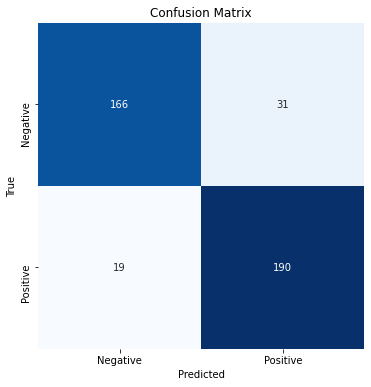

In [39]:
import seaborn as sns

# Print performance metrics
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1 Score: {test_f1_score:.4f}")

# Create confusion matrix
cm = confusion_matrix(test_true_labels, test_predictions)

# Plot confusion matrix
class_names = ['Negative', 'Positive']  # Modify class names based on your dataset
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, square=True,
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()